22H1120016 - Trần Đăng Nam

Lab - nhận diện chữ ký tay KNN và LogisticRegression

- Ma trận confusion matrix (lần lượt cho 2 mô hình)

- Một vài mẫu nhận dạng sai của mô hình này nhưng đúng với mô hình kia (và ngược lại)

- Một vài mẫu nhận dạng sai của cả 2 mô hình

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn import datasets

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.decomposition import PCA
import warnings

In [2]:
# Tắt các cảnh báo không cần thiết (ví dụ: ConvergenceWarning)
warnings.filterwarnings('ignore')

In [3]:
#1. Load dataset & standardize 
digits = datasets.load_digits()

print("Keys của dataset:", digits.keys())
print("Số lượng mẫu:", len(digits.data))
print(digits.data)
print(digits.data.shape)

print("Số lượng features (pixel):", digits.data.shape[0]) 
print("Số lượng lớp (các chữ số):", len(digits.target_names))
print("Tên các lớp:", digits.target_names)
print(digits.feature_names)
print(digits.target)


Keys của dataset: dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'images', 'DESCR'])
Số lượng mẫu: 1797
[[ 0.  0.  5. ...  0.  0.  0.]
 [ 0.  0.  0. ... 10.  0.  0.]
 [ 0.  0.  0. ... 16.  9.  0.]
 ...
 [ 0.  0.  1. ...  6.  0.  0.]
 [ 0.  0.  2. ... 12.  0.  0.]
 [ 0.  0. 10. ... 12.  1.  0.]]
(1797, 64)
Số lượng features (pixel): 1797
Số lượng lớp (các chữ số): 10
Tên các lớp: [0 1 2 3 4 5 6 7 8 9]
['pixel_0_0', 'pixel_0_1', 'pixel_0_2', 'pixel_0_3', 'pixel_0_4', 'pixel_0_5', 'pixel_0_6', 'pixel_0_7', 'pixel_1_0', 'pixel_1_1', 'pixel_1_2', 'pixel_1_3', 'pixel_1_4', 'pixel_1_5', 'pixel_1_6', 'pixel_1_7', 'pixel_2_0', 'pixel_2_1', 'pixel_2_2', 'pixel_2_3', 'pixel_2_4', 'pixel_2_5', 'pixel_2_6', 'pixel_2_7', 'pixel_3_0', 'pixel_3_1', 'pixel_3_2', 'pixel_3_3', 'pixel_3_4', 'pixel_3_5', 'pixel_3_6', 'pixel_3_7', 'pixel_4_0', 'pixel_4_1', 'pixel_4_2', 'pixel_4_3', 'pixel_4_4', 'pixel_4_5', 'pixel_4_6', 'pixel_4_7', 'pixel_5_0', 'pixel_5_1', 'pixel_5_2', 'pixel_5_3',

In [8]:
# Load data 
n_samples = len(digits.images)
data = digits.images.reshape((n_samples, -1)) # Làm phẳng ảnh

# Digits.target = labels  - Split dataset 
X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    data, digits.target, test_size=0.3, random_state=42, stratify=digits.target
)

In [9]:
# Scale dữ liệu
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_raw) # Fit và transform trên tập train
X_test = scaler.transform(X_test_raw)       # Chỉ transform trên tập test

print("Kích thước tập huấn luyện (đã scale):", X_train.shape, y_train.shape)
print("Kích thước tập kiểm tra (đã scale):", X_test.shape, y_test.shape)
print("\nScaling đã được áp dụng.")


Kích thước tập huấn luyện (đã scale): (1257, 64) (1257,)
Kích thước tập kiểm tra (đã scale): (540, 64) (540,)

Scaling đã được áp dụng.


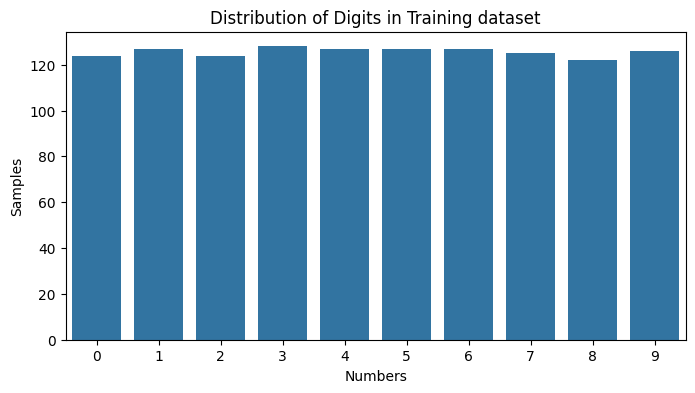

In [10]:
# 2.1 Phân phối các lớp (Digits Distribution) - Histogram
plt.figure(figsize=(8, 4))
sns.countplot(x=y_train)
plt.title('Distribution of Digits in Training dataset') 
plt.xlabel('Numbers')
plt.ylabel('Samples')
plt.show()

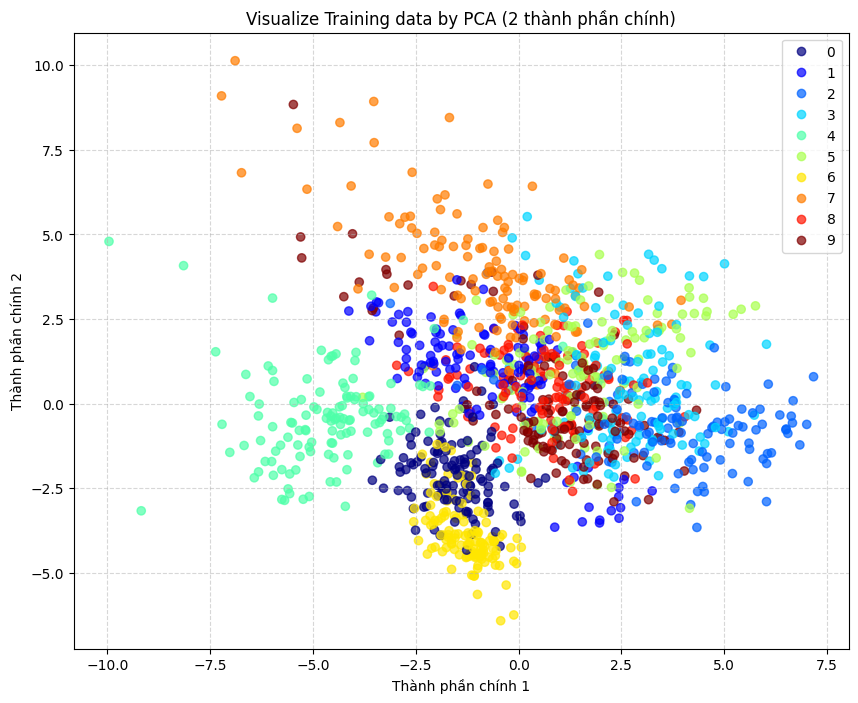

Tỷ lệ phương sai được giải thích bởi 2 thành phần PCA: 0.220
Nhận xét: PCA cho thấy các cụm chữ số có xu hướng tách biệt, nhưng vẫn có sự chồng chéo đáng kể, đặc biệt là giữa các số có hình dạng tương tự.


In [11]:
# 2.2 Trực quan hóa PCA (Principal Component Analysis)
# Giảm chiều dữ liệu xuống 2 chiều để vẽ đồ thị
pca = PCA(n_components=2, random_state=42)
X_train_pca = pca.fit_transform(X_train) # Fit PCA trên tập train đã scale


plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train, cmap=plt.cm.get_cmap("jet", 10), alpha=0.7)
plt.title('Visualize Training data by PCA (2 thành phần chính)')
plt.xlabel('Thành phần chính 1')
plt.ylabel('Thành phần chính 2')

# Lấy cả handles và labels được tạo tự động từ scatter plot
# scatter.legend_elements() trả về một tuple gồm 2 phần:
# - Phần thứ nhất là một list các handles (các đối tượng để plot - marker)
# - Phần thứ hai là một list các labels (dạng string) tương ứng với các handles.

handles, legend_labels = scatter.legend_elements()

# Sử dụng handles và labels này cho legend
plt.legend(handles=handles, labels=legend_labels)
# plt.legend(handles=scatter.legend_elements()[0], labels=digits.target_names) # dòng code này lỗi 0 do labels "ở dạng numpy array" -> không phù hợp


plt.grid(True, linestyle='--', alpha=0.5)
plt.show()
print(f"Tỷ lệ phương sai được giải thích bởi 2 thành phần PCA: {pca.explained_variance_ratio_.sum():.3f}")
print("Nhận xét: PCA cho thấy các cụm chữ số có xu hướng tách biệt, nhưng vẫn có sự chồng chéo đáng kể, đặc biệt là giữa các số có hình dạng tương tự.")



Gridsearch (refit) model -> find the best "hyper params"  😮😮😮


How Gridsearch works:

1. Với mỗi combination của Gridsearch -> nó thực hiện cross-validation (5-fold trong code). 
=> chia X_train, y_train thành 5 phần. Với (fold), train mỗi fold KNN với 4 fold - chừa 1 fold để test (lặp lại 5 lần)

2. Dùng để tính (accuracy) qua 5 fold cho mỗi giá trị k.


3. Huấn luyện lại (Refit - Đây là bước quan trọng):

a. Default (refit=True), sau khi tìm ra bộ tham số tốt nhất (best_params_), GridSearchCV sẽ tự động huấn luyện lại một mô hình KNN mới 

b. grid_search_knn.best_estimator_ (train lại model bằng best_params_) vừa tìm -> LÀ BEST MODEL 

c. Không cần phải train laij "KNeighborsClassifier" --> vì đã extract best model từ gridsearch 



Tham số tốt nhất cho KNN: {'n_neighbors': np.int64(1)}
Độ chính xác tốt nhất trên tập validation (cross-validation): 0.9721


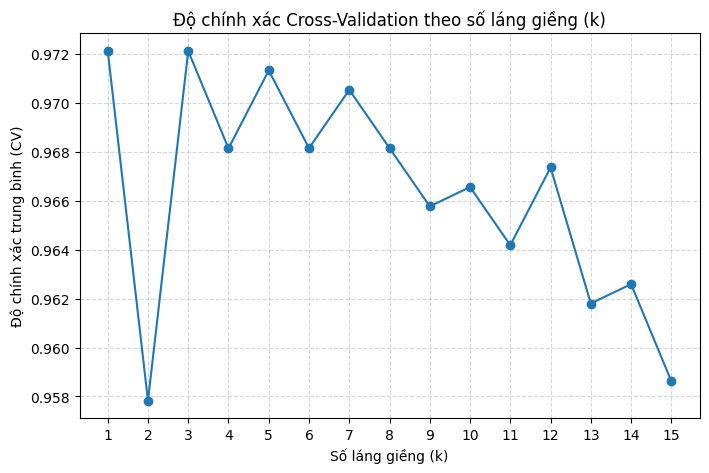

In [12]:
# 3. Tối ưu hóa và Huấn luyện mô hình KNN

# Declare một GridSearchCV để tìm k tốt nhất với 5-fold cross-validation
param_grid_knn = {'n_neighbors': np.arange(1, 16)} # Thử các giá trị k từ 1 đến 15

# Khởi tạo KNN
knn = KNeighborsClassifier()

# Sử dụng GridSearchCV để tìm k tốt nhất với 5-fold cross-validation - find hyperparameters
grid_search_knn = GridSearchCV(
    knn, param_grid_knn, 
    cv=5, 
    scoring='accuracy', 
    n_jobs=-1)

# Train model tìm k tốt nhất (chưa có train model thực tế đâu)
grid_search_knn.fit(X_train, y_train)

# Lấy mô hình KNN tốt nhất từ GridSearchCV -> không cần train lại nữa -> lấy trực tiếp từ grid_search_knn
best_knn = grid_search_knn.best_estimator_
print(f"Tham số tốt nhất cho KNN: {grid_search_knn.best_params_}")
print(f"Độ chính xác tốt nhất trên tập validation (cross-validation): {grid_search_knn.best_score_:.4f}")

# Trực quan hóa kết quả Grid Search cho KNN
plt.figure(figsize=(8, 5))
plt.plot(param_grid_knn['n_neighbors'], grid_search_knn.cv_results_['mean_test_score'], marker='o')
plt.title('Độ chính xác Cross-Validation theo số láng giềng (k)')
plt.xlabel('Số láng giềng (k)')
plt.ylabel('Độ chính xác trung bình (CV)')
plt.xticks(param_grid_knn['n_neighbors'])
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()


In [13]:
# 4. Đánh giá mô hình KNN tối ưu

# Dự đoán trên tập test bằng mô hình KNN tốt nhất
y_pred_knn_best = best_knn.predict(X_test)

# Đánh giá
accuracy_knn_best = accuracy_score(y_test, y_pred_knn_best)
print(f"Độ chính xác (Accuracy) của KNN tối ưu trên tập test: {accuracy_knn_best:.4f}")

print("\nBáo cáo phân loại chi tiết cho KNN tối ưu:")
print(classification_report(y_test, y_pred_knn_best, target_names=[str(i) for i in digits.target_names]))

cm_knn_best = confusion_matrix(y_test, y_pred_knn_best)


Độ chính xác (Accuracy) của KNN tối ưu trên tập test: 0.9741

Báo cáo phân loại chi tiết cho KNN tối ưu:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        54
           1       0.95      0.98      0.96        55
           2       0.98      0.96      0.97        53
           3       0.96      1.00      0.98        55
           4       0.96      0.96      0.96        54
           5       1.00      0.98      0.99        55
           6       0.98      1.00      0.99        54
           7       0.96      1.00      0.98        54
           8       0.96      0.90      0.93        52
           9       0.98      0.94      0.96        54

    accuracy                           0.97       540
   macro avg       0.97      0.97      0.97       540
weighted avg       0.97      0.97      0.97       540



In [14]:
# 5. Tối ưu hóa và Huấn luyện mô hình Logistic Regression

# 'C' là nghịch đảo của độ mạnh regularization (C nhỏ -> regularization mạnh hơn)
# 'solver': một số solver chỉ hoạt động với penalty nhất định ('liblinear' cho l1/l2, 'lbfgs', 'saga' cho l2/none)
# 'saga' thường tốt cho dataset lớn và hỗ trợ nhiều loại penalty

param_grid_logreg = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l2'], # Chỉ dùng l2 cho đơn giản, 'lbfgs' là mặc định và hiệu quả
    'solver': ['lbfgs'] # Solver mặc định, thường hoạt động tốt
    # Nếu muốn thử l1: 'penalty': ['l1', 'l2'], 'solver': ['liblinear', 'saga']
}

# Khởi tạo Logistic Regression
logreg = LogisticRegression(max_iter=5000, random_state=42, multi_class='auto') # multi_class='auto' tự chọn chiến lược phù hợp

# Sử dụng GridSearchCV
print("\nBắt đầu tìm hyperparams cho Logistic Regression...")
grid_search_logreg = GridSearchCV(
    logreg, 
    param_grid_logreg, 
    cv=5, 
    scoring='accuracy', 
    n_jobs=-1)

grid_search_logreg.fit(X_train, y_train)

# Lấy mô hình Logistic Regression tốt nhất
best_logreg = grid_search_logreg.best_estimator_
print(f"Tham số tốt nhất cho Logistic Regression: {grid_search_logreg.best_params_}")
print(f"Độ chính xác tốt nhất trên tập validation (cross-validation): {grid_search_logreg.best_score_:.4f}")




Bắt đầu tìm hyperparams cho Logistic Regression...
Tham số tốt nhất cho Logistic Regression: {'C': 1, 'penalty': 'l2', 'solver': 'lbfgs'}
Độ chính xác tốt nhất trên tập validation (cross-validation): 0.9658


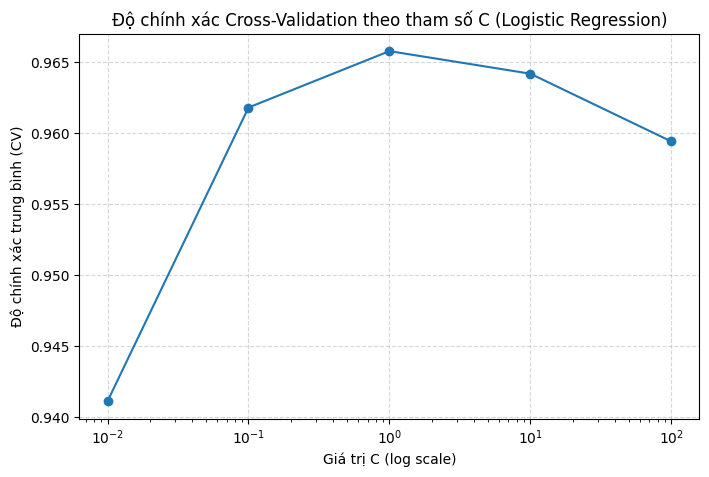

In [15]:
# Trực quan hóa kết quả Grid Search cho LogReg (theo C)
results_logreg = grid_search_logreg.cv_results_
c_values = [params['C'] for params in results_logreg['params']]
mean_scores = results_logreg['mean_test_score']

plt.figure(figsize=(8, 5))
plt.semilogx(c_values, mean_scores, marker='o') # Dùng trục log cho C
plt.title('Độ chính xác Cross-Validation theo tham số C (Logistic Regression)')
plt.xlabel('Giá trị C (log scale)')
plt.ylabel('Độ chính xác trung bình (CV)')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

In [16]:
# 6. Đánh giá mô hình Logistic Regression tối ưu

# Dự đoán trên tập test bằng mô hình LogReg tốt nhất
y_pred_logreg_best = best_logreg.predict(X_test)

# Đánh giá
accuracy_logreg_best = accuracy_score(y_test, y_pred_logreg_best)
print(f"Độ chính xác (Accuracy) của Logistic Regression tối ưu trên tập test: {accuracy_logreg_best:.4f}")

print("\nBáo cáo phân loại chi tiết cho Logistic Regression tối ưu:")
print(classification_report(y_test, y_pred_logreg_best, target_names=[str(i) for i in digits.target_names]))

cm_logreg_best = confusion_matrix(y_test, y_pred_logreg_best)

Độ chính xác (Accuracy) của Logistic Regression tối ưu trên tập test: 0.9815

Báo cáo phân loại chi tiết cho Logistic Regression tối ưu:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        54
           1       0.95      0.95      0.95        55
           2       1.00      1.00      1.00        53
           3       1.00      1.00      1.00        55
           4       0.98      0.98      0.98        54
           5       1.00      0.98      0.99        55
           6       1.00      0.98      0.99        54
           7       1.00      1.00      1.00        54
           8       0.91      0.94      0.92        52
           9       0.98      0.98      0.98        54

    accuracy                           0.98       540
   macro avg       0.98      0.98      0.98       540
weighted avg       0.98      0.98      0.98       540



In [17]:
# 7. So sánh kết quả hai mô hình tối ưu

print("--- So Sánh Hiệu Năng (Sau Tối Ưu Hóa) ---")
print(f"KNN Tối Ưu Accuracy:                 {accuracy_knn_best:.4f}")
print(f"Logistic Regression Tối Ưu Accuracy: {accuracy_logreg_best:.4f}")

if accuracy_knn_best > accuracy_logreg_best:
    print("\nMô hình KNN tối ưu có độ chính xác cao hơn trên tập kiểm tra.")
elif accuracy_logreg_best > accuracy_knn_best:
    print("\nMô hình Logistic Regression tối ưu có độ chính xác cao hơn trên tập kiểm tra.")
else:
    print("\nHai mô hình tối ưu có độ chính xác bằng nhau trên tập kiểm tra.")




--- So Sánh Hiệu Năng (Sau Tối Ưu Hóa) ---
KNN Tối Ưu Accuracy:                 0.9741
Logistic Regression Tối Ưu Accuracy: 0.9815

Mô hình Logistic Regression tối ưu có độ chính xác cao hơn trên tập kiểm tra.


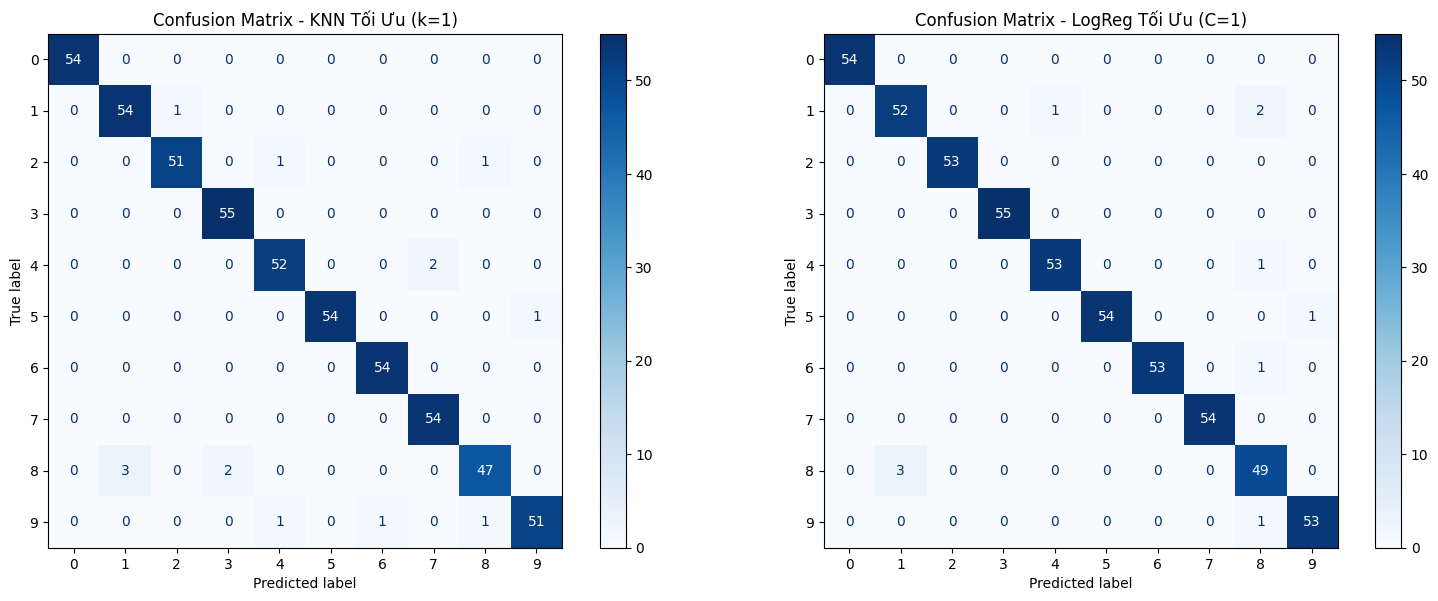

In [18]:
# 8. Trực quan hóa Confusion Matrix (cho mô hình tối ưu)

# Vẽ confusion matrix cho cả hai mô hình TỐI ƯU
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Confusion Matrix cho KNN tối ưu
disp_knn_best = ConfusionMatrixDisplay(confusion_matrix=cm_knn_best, display_labels=digits.target_names)
disp_knn_best.plot(ax=axes[0], cmap=plt.cm.Blues)
axes[0].set_title(f'Confusion Matrix - KNN Tối Ưu (k={best_knn.n_neighbors})')

# Confusion Matrix cho Logistic Regression tối ưu
disp_logreg_best = ConfusionMatrixDisplay(confusion_matrix=cm_logreg_best, display_labels=digits.target_names)
disp_logreg_best.plot(ax=axes[1], cmap=plt.cm.Blues)
axes[1].set_title(f'Confusion Matrix - LogReg Tối Ưu (C={best_logreg.C})')

plt.tight_layout()
plt.show()

In [19]:
# 9. Phân tích và trực quan hóa các mẫu nhận dạng sai (cho mô hình tối ưu)


# Tìm các chỉ số lỗi cho mô hình TỐI ƯU
knn_correct_best = (y_test == y_pred_knn_best)
logreg_correct_best = (y_test == y_pred_logreg_best)

# Lỗi KNN nhưng LogReg đúng
knn_wrong_logreg_right_indices_best = np.where(~knn_correct_best & logreg_correct_best)[0]
# Lỗi LogReg nhưng KNN đúng
logreg_wrong_knn_right_indices_best = np.where(knn_correct_best & ~logreg_correct_best)[0]
# Cả hai cùng lỗi
both_wrong_indices_best = np.where(~knn_correct_best & ~logreg_correct_best)[0]

print(f"Số mẫu KNN tối ưu sai, LogReg tối ưu đúng: {len(knn_wrong_logreg_right_indices_best)}")
print(f"Số mẫu LogReg tối ưu sai, KNN tối ưu đúng: {len(logreg_wrong_knn_right_indices_best)}")
print(f"Số mẫu cả hai mô hình tối ưu cùng sai:     {len(both_wrong_indices_best)}")


Số mẫu KNN tối ưu sai, LogReg tối ưu đúng: 9
Số mẫu LogReg tối ưu sai, KNN tối ưu đúng: 5
Số mẫu cả hai mô hình tối ưu cùng sai:     5


In [20]:
# Hàm trợ plot (sử dụng lại hàm cũ, nhưng với dự đoán mới)
# Đảm bảo hàm plot_misclassified_samples đã được định nghĩa ở cell trước đó

def plot_misclassified_samples_optimized(indices, title, max_samples=8):
    """Vẽ các ảnh bị phân loại sai bởi các mô hình TỐI ƯU."""
    if len(indices) == 0:
        print(f"Không có mẫu nào cho trường hợp: {title}")
        return

    sample_indices = indices[:min(len(indices), max_samples)]
    num_samples = len(sample_indices)
    num_cols = min(num_samples, 4)
    num_rows = (num_samples + num_cols - 1) // num_cols

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * 1.5, num_rows * 3 )) # Tăng chiều cao một chút
    if num_rows == 1 and num_cols == 1: axes = np.array([[axes]])
    elif num_rows == 1: axes = axes.reshape(1, -1)
    elif num_cols == 1: axes = axes.reshape(-1, 1)

    fig.suptitle(title, fontsize=14)

    for i, test_idx in enumerate(sample_indices):
        row, col = divmod(i, num_cols)
        ax = axes[row, col]
        # Lấy ảnh gốc chưa scale để hiển thị
        image = X_test_raw[test_idx].reshape(8, 8)
        true_label = y_test[test_idx]
        knn_pred = y_pred_knn_best[test_idx]
        logreg_pred = y_pred_logreg_best[test_idx]

        ax.imshow(image, cmap=plt.cm.gray_r, interpolation="nearest")
        ax.set_title(f"True: {true_label}\nKNN*: {knn_pred}, LR*: {logreg_pred}") # Đánh dấu * cho mô hình tối ưu
        ax.set_axis_off()

    for i in range(num_samples, num_rows * num_cols):
         row, col = divmod(i, num_cols)
         if row < axes.shape[0] and col < axes.shape[1]:
            axes[row, col].set_axis_off()

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()



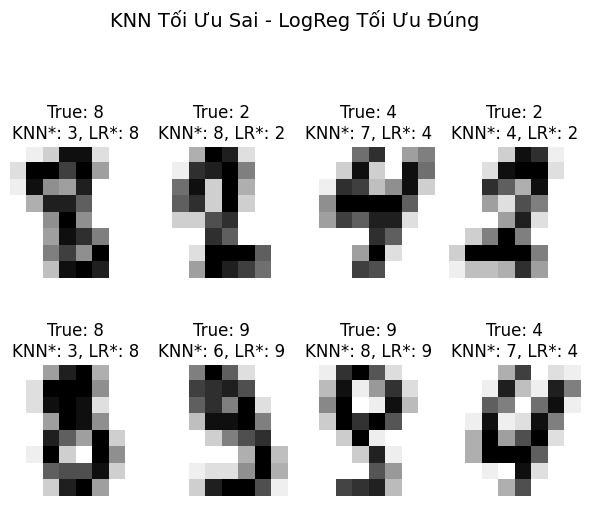

In [21]:
# 9.1 Mẫu KNN tối ưu sai, Logistic Regression tối ưu đúng
plot_misclassified_samples_optimized(knn_wrong_logreg_right_indices_best, "KNN Tối Ưu Sai - LogReg Tối Ưu Đúng")


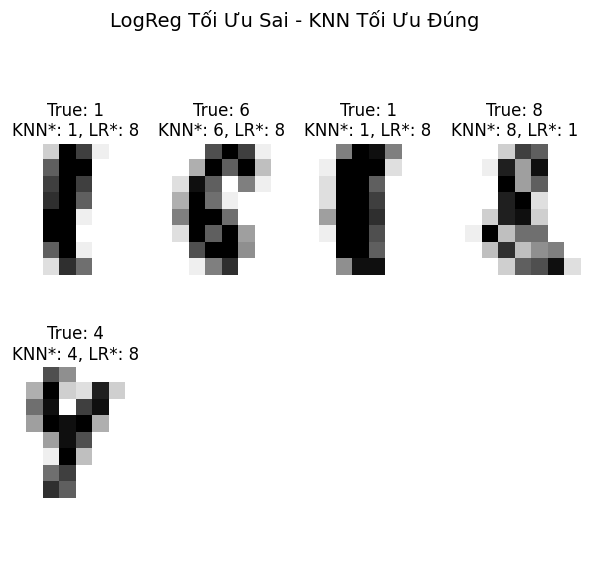

In [22]:
# 9.2 Mẫu Logistic Regression tối ưu sai, KNN tối ưu đúng
plot_misclassified_samples_optimized(logreg_wrong_knn_right_indices_best, "LogReg Tối Ưu Sai - KNN Tối Ưu Đúng")



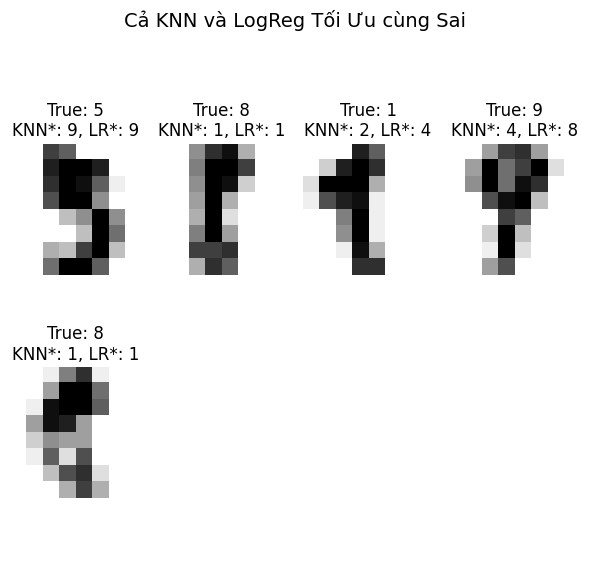

In [23]:
# 9.3 Mẫu cả hai mô hình tối ưu cùng nhận dạng sai
plot_misclassified_samples_optimized(both_wrong_indices_best, "Cả KNN và LogReg Tối Ưu cùng Sai")

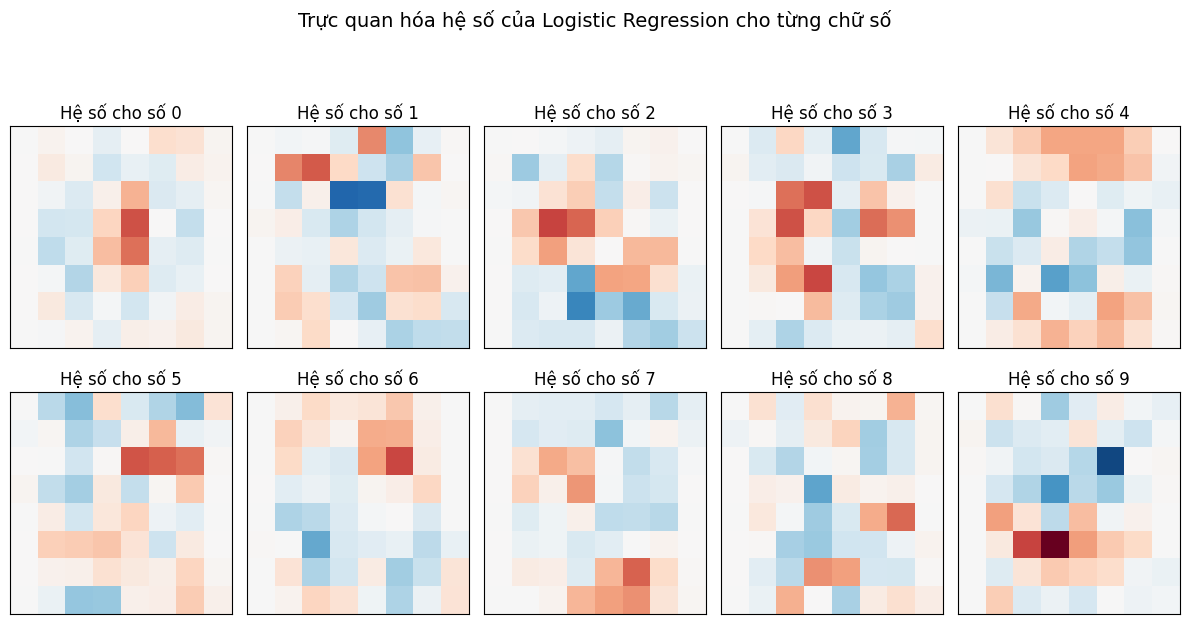

Nhận xét: Màu đỏ cho biết pixel đó có trọng số dương (quan trọng để nhận diện số đó), màu xanh dương là trọng số âm (quan trọng để loại trừ số đó). Có thể thấy mô hình học được hình dạng cơ bản của các chữ số.


In [24]:
# 10. Trực quan hóa bổ sung (Thêm)
# 10.1 Hệ số (Coefficients) của Logistic Regression
# Các hệ số này cho biết tầm quan trọng của mỗi pixel đối với việc phân loại từng chữ số (trong chiến lược one-vs-rest hoặc multinomial). Giá trị dương lớn cho biết pixel đó bật sáng thì khả năng là chữ số đó cao, giá trị âm lớn thì ngược lại.

# Lấy các hệ số từ mô hình Logistic Regression tốt nhất
coefs = best_logreg.coef_

# Vẽ heatmap cho các hệ số của từng lớp
plt.figure(figsize=(12, 7))
scale = np.abs(coefs).max() # Dùng để chuẩn hóa màu sắc
for i in range(len(digits.target_names)):
    plt.subplot(2, 5, i + 1) # 2 hàng, 5 cột
    plt.imshow(coefs[i].reshape(8, 8), cmap=plt.cm.RdBu, vmin=-scale, vmax=scale)
    plt.title(f'Hệ số cho số {i}')
    plt.xticks(())
    plt.yticks(())

plt.suptitle('Trực quan hóa hệ số của Logistic Regression cho từng chữ số', fontsize=14)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()
print("Nhận xét: Màu đỏ cho biết pixel đó có trọng số dương (quan trọng để nhận diện số đó), màu xanh dương là trọng số âm (quan trọng để loại trừ số đó). Có thể thấy mô hình học được hình dạng cơ bản của các chữ số.")


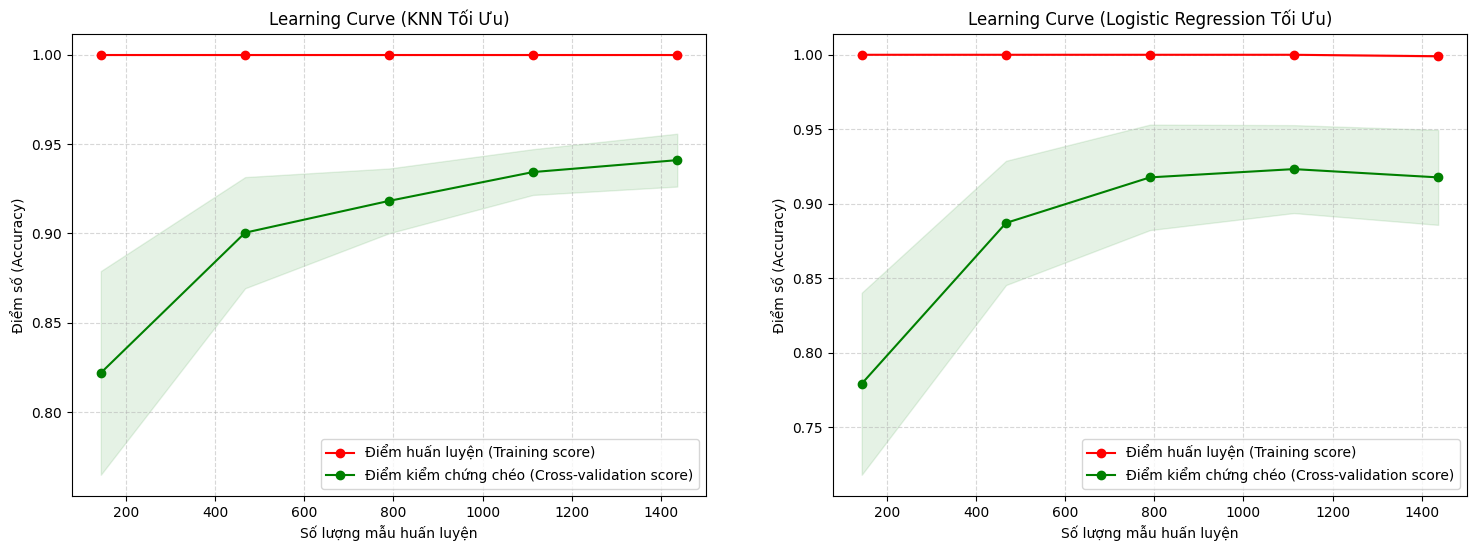

Nhận xét Learning Curves:
- Cả hai mô hình đều cho thấy điểm huấn luyện (màu đỏ) cao và điểm cross-validation (màu xanh) cũng khá cao và gần với điểm huấn luyện khi dùng nhiều dữ liệu hơn.
- Khoảng cách nhỏ giữa hai đường cong cho thấy mô hình không bị overfitting quá nghiêm trọng.
- Điểm số trên validation có xu hướng đi ngang khi tăng dữ liệu, cho thấy việc thêm dữ liệu tương tự có thể không cải thiện hiệu năng nhiều nữa với các mô hình này. Có thể cần mô hình phức tạp hơn hoặc feature engineering để cải thiện thêm.


In [25]:
# 10.2 Learning Curves (Đường cong học)
# Learning curves cho thấy hiệu năng của mô hình (trên tập huấn luyện và tập validation) thay đổi như thế nào khi tăng kích thước tập huấn luyện. Nó giúp chẩn đoán overfitting (khoảng cách lớn giữa 2 đường) hoặc underfitting (cả 2 đường đều thấp).

def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """Vẽ learning curve cho một estimator."""
    if axes is None:
        _, axes = plt.subplots(1, 1, figsize=(10, 6))

    axes.set_title(title)
    if ylim is not None:
        axes.set_ylim(*ylim)
    axes.set_xlabel("Số lượng mẫu huấn luyện")
    axes.set_ylabel("Điểm số (Accuracy)")

    train_sizes, train_scores, test_scores = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes, scoring="accuracy")

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    # Vẽ vùng thể hiện độ lệch chuẩn
    axes.fill_between(train_sizes, train_scores_mean - train_scores_std,
                      train_scores_mean + train_scores_std, alpha=0.1, color="r")
    axes.fill_between(train_sizes, test_scores_mean - test_scores_std,
                      test_scores_mean + test_scores_std, alpha=0.1, color="g")

    # Vẽ đường trung bình
    axes.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Điểm huấn luyện (Training score)")
    axes.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Điểm kiểm chứng chéo (Cross-validation score)")
    axes.legend(loc="best")
    axes.grid(True, linestyle='--', alpha=0.5)

    return plt

# Vẽ Learning Curve cho KNN tối ưu và Logistic Regression tối ưu
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Sử dụng toàn bộ dữ liệu X (đã scale) và y để vẽ learning curve với cross-validation
X_scaled_full = scaler.transform(data) # Scale toàn bộ dữ liệu X gốc

plot_learning_curve(best_knn, "Learning Curve (KNN Tối Ưu)",
                    X_scaled_full, digits.target, axes=axes[0], cv=5, n_jobs=-1) # cv=5 như trong GridSearchCV

plot_learning_curve(best_logreg, "Learning Curve (Logistic Regression Tối Ưu)",
                    X_scaled_full, digits.target, axes=axes[1], cv=5, n_jobs=-1)

plt.show()

print("Nhận xét Learning Curves:")
print("- Cả hai mô hình đều cho thấy điểm huấn luyện (màu đỏ) cao và điểm cross-validation (màu xanh) cũng khá cao và gần với điểm huấn luyện khi dùng nhiều dữ liệu hơn.")
print("- Khoảng cách nhỏ giữa hai đường cong cho thấy mô hình không bị overfitting quá nghiêm trọng.")
print("- Điểm số trên validation có xu hướng đi ngang khi tăng dữ liệu, cho thấy việc thêm dữ liệu tương tự có thể không cải thiện hiệu năng nhiều nữa với các mô hình này. Có thể cần mô hình phức tạp hơn hoặc feature engineering để cải thiện thêm.")




## Kết luận (Thêm)

Qua quá trình tối ưu hóa và đánh giá:

*   Dùng **Scaling** và **GridSearchCV** tìm hyperparams KNN và Logistic Regression.

*   **Confusion Matrix** của các mô hình tối ưu cho thấy [Liệt kê các cặp số vẫn còn bị nhầm lẫn nhiều nhất, ví dụ: (8, 1), (9, 4)]. Mặc dù hiệu năng tổng thể tốt, những trường hợp khó này vẫn tồn tại.

*   Phân tích **mẫu lỗi sai** giữa hai mô hình tối ưu tiếp tục cho thấy sự khác biệt trong cách chúng xử lý các trường hợp nhập nhằng hoặc không điển hình.

*   **Trực quan hóa PCA** -> show dữ liệu có cấu trúc cụm, nhưng vẫn có sự chồng lấn (overlap lên nhay).
*   **Hệ số Logistic Regression** cho thấy mô hình học được các vùng pixel quan trọng tương ứng với hình dạng chữ số.
*   **Learning Curves** chỉ ra rằng với lượng dữ liệu hiện có, cả hai mô hình đều học khá tốt mà không bị overfitting quá mức, nhưng có thể đã đạt đến giới hạn hiệu năng của chúng trên bộ dữ liệu này.